Homework 2

Harsh Bhatt (hb371)

# Generating Decision Trees

## Generating a dataset according to the given scheme

In [244]:
from random import choices
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [245]:
class GenerateDataset:

    def __init__(self, k):
        self.weights, self.y_array, self.x_array = [], [], []
        # Generate Weights
        weight_sum = 0
        for i in range(2, k + 1):
            weight_sum += 0.9 ** i

        for i in range(2, k + 1):
            wi = (0.9 ** i) / weight_sum
            self.weights.append(wi)

    def generate_y_values(self, x_values, k):
        check_sum = 0
        y = -1
        for i in range(1, k):
            check_sum += self.weights[i - 1] * x_values[i]
        if check_sum >= 0.5:
            y = x_values[0]
        else:
            y = 1 - x_values[0]
        return y

    def generate_data_points(self, k):
        x_values = [choices([0, 1], [0.5, 0.5])[0]]

        for i in range(1, k):
            x_values.append(choices([x_values[i - 1], (1 - x_values[i - 1])], [0.75, 0.25])[0])
        y_value = self.generate_y_values(x_values, k)
        self.y_array.append(y_value)
        self.x_array.append(x_values)

    def generate(self, m, k):
        for i in range(m):
            self.generate_data_points(k)
        return np.array(self.x_array), np.array(self.y_array)
obj = GenerateDataset(4)
a, b = obj.generate(10, 4)
print(a,b)

[[1 1 0 0]
 [0 1 1 1]
 [1 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 1 1 0]
 [0 0 0 0]
 [0 0 1 1]
 [0 0 1 1]
 [1 1 1 1]] [0 0 0 0 1 1 1 0 0 1]


## Creating a Decision Tree using ID3 algorithm

In [246]:
class Node:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTree:
    flag = "a"

    def __init__(self):
        self.root = None

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return Node(label_name=label_name)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return Node(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        if entropy == 0:
            value = self.max_counter(y)
            return Node(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        # left_split, right_split = np.array(left_indices), np.array(right_indices)
        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes)
        return Node(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        entropy, split_index, split_value = -1, None, None
        for column in indexes:
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def print_tree(self, root):
        if root.feature is None and root.label_name is None:
            return

        queue = [root, self.flag]

        while True:
            current = queue.pop(0)
            if current != "a":
                if current.label_name is not None:
                    print("Value = {}, Entropy = {}".format(current.label_name, current.entropy, end=" "))
                else:
                    print("Feature = {}, Samples = {}, Counts = {}, Entropy = {}".format(current.feature,
                                                                                         current.samples,
                                                                                         current.counts,
                                                                                         current.entropy, end=" "))
                if current.left is not None:
                    queue.append(current.left)
                if current.right is not None:
                    queue.append(current.right)
            else:
                print("")
                if len(queue) == 0:
                    break
                else:
                    queue.append(self.flag)


In [270]:
#This is the function which will calculate the error from our actual data labels and the predicted labels.

def error(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return 1 - accuracy

In [248]:
data_obj = GenerateDataset(4)
x_train, y_train = data_obj.generate(30, 4)

clf = DecisionTree()
clf.train(x_train, y_train)

y_pred = clf.predict(x_train)
myerror = error(y_train, y_pred)

print("Error on training data is ", myerror)


Error on training data is  0.0


## Generation of data and fit a decision tree

In [94]:
data_obj = GenerateDataset(4)
x_train, y_train = data_obj.generate(30, 4)

clf = DecisionTree()
clf.train(x_train, y_train)

print(x_train, y_train)
clf.print_tree(clf.root)

[[1 1 1 0]
 [0 0 0 0]
 [1 0 1 0]
 [1 1 1 1]
 [0 0 0 1]
 [0 0 0 0]
 [1 1 1 1]
 [1 0 1 1]
 [0 0 0 0]
 [1 1 1 1]
 [0 1 0 1]
 [1 1 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 1]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [0 0 1 1]
 [1 0 0 0]] [1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]
Feature = 0, Samples = 30, Counts = [ 7 23], Entropy = 0.02977592679451746

Feature = 3, Samples = 14, Counts = [ 2 12], Entropy = 0.3059584928680418
Feature = 3, Samples = 16, Counts = [ 5 11], Entropy = 0.6522798244164246

Value = 1, Entropy = None
Feature = 1, Samples = 4, Counts = [2 2], Entropy = 0.31127812445913283
Feature = 1, Samples = 6, Counts = [5 1], Entropy = 0.6500224216483541
Value = 1, Entropy = None

Feature = 2, Samples = 3, Counts = [1 2], Entropy = 0.9182958340544896
Value = 0, Entropy = None
Feature = 2, Samples = 3, Counts = [2 1], Entropy = 0.9182958340544896
Value = 0, Entropy

The ordering matters as the feature with highest IG is chosen at first. As we go down, we have comparatively "pure" data so we expect higher entropy. But if we swap a feature down the branch with one of its parent, then the distribution of data points based on that feature would not be optimal. Hence our decision tree would not give out accurate results.

![title](image.JPG)

## Find the typical (Average) error

In [112]:
#Function to calculate averge error
def average_error(y):
    total, average = 0, 0
    for i in y:
        total += i
    average = total / len(y)
    return average * 100

# As we have made a decision tree in the previous question, we would just use that tree to test our data now.
y = []
i = 0
while i <= 200:
    
    new_obj = GenerateDataset(4)
    x_test, y_test = new_obj.generate(2000, 4)
    
    y_pred = clf.predict(x_test)
    acc = error(y_test, y_pred)
    y.append(acc)
    
    i += 1

print(y_test[:10], y_pred[:10])
print("Average Error = {}%".format(average_error(y)))

[0 0 1 1 1 0 1 1 0 1] [0 0 1 1 1 0 1 1 0 1]
Average Error = 4.659452736318411%


As we can see from above, the average error is = 4.694%

## For k = 10, finding error and making graph

In [120]:
def graph(x, y):
    plt.plot(x, y, label="ID3 ", color="red")
    plt.xlabel("m values")
    plt.ylabel(" $|err_{test} - err_{train}|$")
    plt.title("ID3")
    plt.legend()
    plt.show()


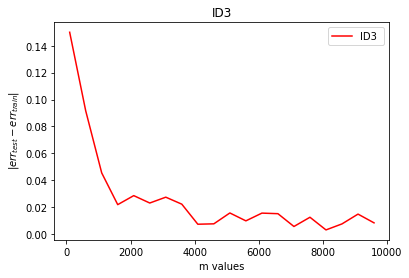

In [126]:
x, y = [], []
for i in range(100, 10000, 500):
    data_obj = GenerateDataset(10)
    x_dataset, y_dataset = data_obj.generate(i, 10)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree()
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = error(y_train, y_train_pred)

    y.append(abs(acc - acc1))
    x.append(i)

graph(x, y)

We can say by looking at the graph that as we have more number of training datapoints, our decision tree that is bulit understands the underlying distribution of data very well.

## Alternative Metric - Gini Index

In [131]:
class Node_gini:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTree_gini:
    flag = "a"

    def __init__(self):
        self.root = None

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return Node_gini(label_name=label_name)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return Node_gini(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        if entropy == 0:
            value = self.max_counter(y)
            return Node_gini(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes)
        return Node_gini(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        best_gain, split_index, split_value = 0, None, None
        for column in indexes:
            X_column = x_array[:, column]
            left, right = np.array([]), np.array([])
            for value in unique_y:
                for i in range(len(X_column)):
                    if X_column[i] == value:
                        np.append(left, i)
                    else:
                        np.append(right, i)

                if len(left) == 0 or len(right) == 0:
                    continue

                gain = self.information_gain(left, right)
                if gain < best_gain:
                    best_gain = gain
                    split_index = column
                    split_value = value

        return split_index, best_gain, split_value

    def information_gain(self, left, right):
        probability = len(left) / (len(left) + len(right))
        return (probability * self.gini(left)) - ((1-probability) * self.gini(right))

    def gini(self, rows):
        length = len(rows)
        counts = np.bincount(rows)
        impurity = 1
        for i in range(len(counts)):
            prob = counts[i] / length
            impurity -= prob**2
        return impurity

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def print_tree(self, root):
        if root.feature is None and root.label_name is None:
            return

        queue = [root, self.flag]

        while True:
            current = queue.pop(0)
            if current != "a":
                if current.label_name is not None:
                    print("Value = {}, Entropy = {}".format(current.label_name, current.entropy, end=" "))
                else:
                    print("Feature = {}, Samples = {}, Counts = {}, Entropy = {}".format(current.feature,
                                                                                         current.samples,
                                                                                         current.counts,
                                                                                         current.entropy, end=" "))
                if current.left is not None:
                    queue.append(current.left)
                if current.right is not None:
                    queue.append(current.right)
            else:
                print("")
                if len(queue) == 0:
                    break
                else:
                    queue.append(self.flag)


Testing gini on dataset

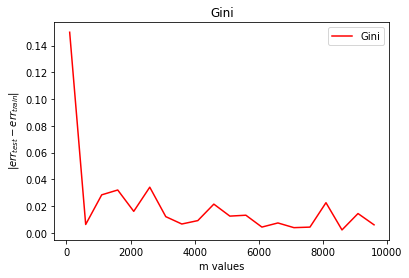

In [268]:
def gini_graph(x, y):
    plt.plot(x, y, label="Gini", color="red")
    plt.xlabel("m values")
    plt.ylabel(" $|err_{test} - err_{train}|$")
    plt.title("Gini")
    plt.legend()
    plt.show()

gx, gy = [], []
for i in range(100, 10000, 500):
    data_obj = GenerateDataset(10)
    gx_dataset, gy_dataset = data_obj.generate(i, 10)
    gx_train, gx_test, gy_train, gy_test = train_test_split(gx_dataset, gy_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree_gini()
    clf.train(gx_train, gy_train)

    gy_pred = clf.predict(gx_test)
    acc = error(gy_test, gy_pred)

    gy_train_pred = clf.predict(gx_train)
    acc1 = error(gy_train, gy_train_pred)

    gy.append(abs(acc - acc1))
    gx.append(i)

gini_graph(gx, gy)

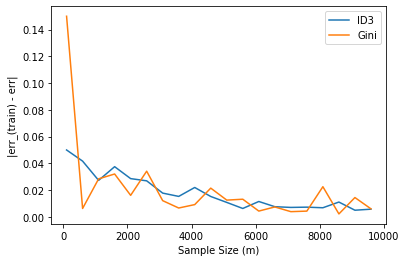

In [269]:
plt.plot(x,y)
plt.plot(gx, gy)
plt.xlabel("Sample Size (m)")
plt.ylabel("|err_(train) - err|")
plt.legend(["ID3", "Gini"])
plt.show()

We can compare the two methods using the above graph. As we see, the error for both metrics is almost same but the error for Gini Index starts very high and then it keeps fluctuating in a small range of errors. The final probability is same for both the metrics when the sample size is maximum for the given iteration.

# Pruning Decision Trees

## Generating dataset by a scheme

In [160]:
class GenerateDataset2:
    def __init__(self):
        self.x_array, self.y_array = [], []
        
    def generate_y_values(self, x_values):
        if x_values[0] == 0:
            y = Counter(x_values[1:8]).most_common()[0][0]
        else:
            y = Counter(x_values[8:15]).most_common()[0][0]
        return y

    def generate_data_points(self):
        x_values = [choices([0, 1], [0.5, 0.5])[0]]

        for i in range(1, 15):
            x_values.append(choices([x_values[i - 1], (1 - x_values[i - 1])], [0.75, 0.25])[0])
        for i in range(15, 22):
            x_values.append(choices([1, 0], [0.5, 0.5])[0])
        y_value = self.generate_y_values(x_values)
        self.x_array.append(x_values)
        self.y_array.append(y_value)

    def generate(self, m):
        for i in range(m):
            self.generate_data_points()
        return np.array(self.x_array), np.array(self.y_array)

In [188]:
class Node2:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTree2:
    flag = "a"

    def __init__(self):
        self.root = None
        self.irrelevant_array, self.relevant_array = [], []

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return Node(label_name=label_name)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return Node(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        
        if feature_index in [15, 16, 17, 18, 19, 20]:
            self.irrelevant_array.append(feature_index)
            
        if entropy == 0:
            value = self.max_counter(y)
            return Node(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes)
        return Node(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        entropy, split_index, split_value = -1, None, None
        for column in indexes:
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def check_irrelevant(self):
        return len(set(self.irrelevant_array))
    
    def print_tree(self, root):
        if root.feature is None and root.label_name is None:
            return

        queue = [root, self.flag]

        while True:
            current = queue.pop(0)
            if current != "a":
                if current.label_name is not None:
                    print("Value = {}, Entropy = {}".format(current.label_name, current.entropy, end=" "))
                else:
                    print("Feature = {}, Samples = {}, Counts = {}, Entropy = {}".format(current.feature,
                                                                                         current.samples,
                                                                                         current.counts,
                                                                                         current.entropy, end=" "))
                if current.left is not None:
                    queue.append(current.left)
                if current.right is not None:
                    queue.append(current.right)
            else:
                print("")
                if len(queue) == 0:
                    break
                else:
                    queue.append(self.flag)

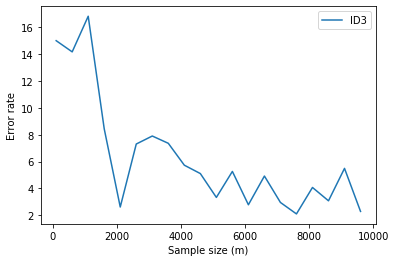

In [264]:
ax, ay = [], []
for i in range(100, 10000, 500):
    data_obj = GenerateDataset2()
    ax_dataset, ay_dataset = data_obj.generate(i) #here, k would always be 20
    ax_train, ax_test, ay_train, ay_test = train_test_split(ax_dataset, ay_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree2()
    clf.train(ax_train, ay_train)

    ay_pred = clf.predict(ax_test)
    acc = error(ay_test, ay_pred)

    ay_train_pred = clf.predict(ax_train)
    acc1 = error(ay_train, ay_train_pred)

    ay.append(100*abs(acc - acc1))
    ax.append(i)

plt.plot(ax,ay)
plt.legend(["ID3"])
plt.xlabel("Sample size (m)")
plt.ylabel("Error rate")
plt.show()

We can agree with this intuition that after getting more datapoints to train, the algorithm gets better.After we got the sample values for around 4000, our error rate stabilized a bit. So getting more datapoints helped in our algorithm to learn better.

## Irrelevant variables included in the tree

In [192]:
ax, ay, irr, count = [], [], [], 0
for i in range(1000, 35000, 2000):
    data_obj = GenerateDataset2()
    ax_dataset, ay_dataset = data_obj.generate(i) 
    ax_train, ax_test, ay_train, ay_test = train_test_split(ax_dataset, ay_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree2()
    clf.train(ax_train, ay_train)
    
    a = clf.check_irrelevant()
    count += a
    irr.append(a)
    
    ay_pred = clf.predict(ax_test)
    acc = error(ay_test, ay_pred)

    ay_train_pred = clf.predict(ax_train)
    acc1 = error(ay_train, ay_train_pred)

    ay.append(abs(acc - acc1))
    ax.append(i)

print(count/len(irr))

6.0


For my algorithm, I am getting an average number of 6 irrelevant datapoints in my tree. In our dataset generation, we 6 features which are irrelevant i.e. from feature 15 to 20. So, the maximum number of irrelevant features a decision tree can have is 6. 

We see that at around 35000 datapoints, our model will not give any irrelevant features or the value would be lower than 1. And as have 15 relevant features in our dataset i.e. 0 to 14, so the number of relevant datapoints would be 2^15 = 32000. The answer is similar to the reasoning hence we can say that 35000 datapoints is required for no irrelevant data.

## Pruning by Depth

In [208]:
class NodeDepth:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTreeDepth:
    flag = "a"

    def __init__(self, max_depth):
        self.root = None
        self.max_depth = max_depth
        self.irrelevant_array, self.relevant_array = [], []

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices, depth = 0):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return NodeDepth(label_name=label_name)
        
        if depth >= self.max_depth:
            value = self.max_counter(y)
            return NodeDepth(label_name = value)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return NodeDepth(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        
        if feature_index in [15, 16, 17, 18, 19, 20]:
            self.irrelevant_array.append(feature_index)
            
        if entropy == 0:
            value = self.max_counter(y)
            return NodeDepth(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes, depth+1)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes, depth+1)
        return NodeDepth(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        entropy, split_index, split_value = -1, None, None
        for column in indexes:
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def check_irrelevant(self):
        return len(set(self.irrelevant_array))

In [272]:
x, y, z = [], [], []
it = [i for i in range(0, 15)]
for i in range(0, 15):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeDepth(i)
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = 100*error(y_train, y_train_pred)

    y.append(acc)
    z.append(acc1)

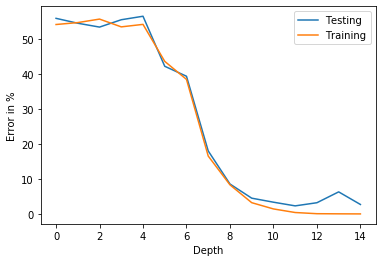

In [273]:
plt.plot(it,y)
plt.plot(it, z)
plt.xlabel("Depth")
plt.ylabel("Error in %")
plt.legend(["Testing", "Training"])
plt.show()

From the graph, we can see that after depth of around 11, the line for testing error flattens a bit. This is due to the intuition that as we have 15 relevant features and if we consider the relevant features only, then, our error could be minimized. So, we see if the depth is 0-6, it cannot consider lot of variables and as a result gives much error.

## Pruning by Sample Size

In [228]:
class NodeSample:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTreeSample:
    flag = "a"

    def __init__(self, min_sample):
        self.root = None
        self.min_sample = min_sample
        self.irrelevant_array, self.relevant_array = [], []

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return NodeSample(label_name=label_name)
        
        if len(y) <= self.min_sample:
            value = self.max_counter(y)
            return NodeSample(label_name = value)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return NodeSample(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        
        if feature_index in [15, 16, 17, 18, 19, 20]:
            self.irrelevant_array.append(feature_index)
            
        if entropy == 0:
            value = self.max_counter(y)
            return NodeSample(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes)
        return NodeSample(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        entropy, split_index, split_value = -1, None, None
        for column in indexes:
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def check_irrelevant(self):
        return len(set(self.irrelevant_array))

In [254]:
x, y, z = [], [], []
it = [i for i in range(0, 2000, 200)]
for i in range(0, 2000, 200):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeSample(i)
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = 100*error(y_train, y_train_pred)

    y.append(acc)
    z.append(acc1)

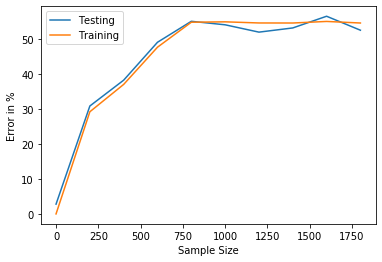

In [255]:
plt.plot(it,y)
plt.plot(it, z)
plt.xlabel("Sample Size")
plt.ylabel("Error in %")
plt.legend(["Testing", "Training"])
plt.show()

From the graph shown above, we can see that if the maximum sample size is greater than 700, we will get more error around 50%. After that, the line fluctuates a little bit only.

## Finding spurious data after pruning sample by depth

In [263]:
y, count = [], 0
for i in range(0, 20):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeDepth(11)
    clf.train(x_train, y_train)
    
    a = clf.check_irrelevant()
    count += a
    y.append(a)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

print(count/len(y))


5.95


From question 2), the average number of irrelevant data that was gotten was 6. But after pruning the decision tree by depth, that average reduced by a bit to $5.95$. So, this shows that the likelihood of spurious data decreases if we prune the tree by an optimal depth.

## Finding spurious data after pruning sample by sample size

In [262]:
y, count = [], 0
for i in range(0, 20):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeSample(400)
    clf.train(x_train, y_train)
    
    a = clf.check_irrelevant()
    count += a
    y.append(a)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

print(count/len(y))

1.8


The number of spurious data reduces significantly from 6 when no pruning was applied to $1.8$ after pruning by sample size. We can therefore say that after applying pruning by sample size, we get much more optimized tree with respect to spurious data.